# Mean Force Integration

Import HILLS and COLVAR files, compute the mean force and integrate using the pyMFI (would be) module. 

In [1]:
from pyMFI import MFI

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 10, error_pace = 200, WellTempered=1, nhills=1000)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

#Simpler integration
[X, Y, FES2] = MFI.intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history)

Total no. of Gaussians analysed: 1000


TypeError: only integer scalar arrays can be converted to a scalar index

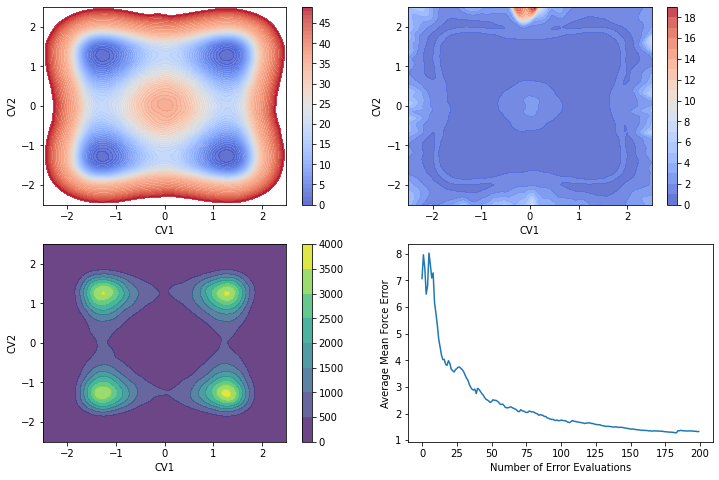

In [3]:
# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history)

5000 / 50000 Average Error: 3.9819043191823478
10000 / 50000 Average Error: 2.7501673788880505
15000 / 50000 Average Error: 2.2993513821153746
20000 / 50000 Average Error: 2.0601668108204882
25000 / 50000 Average Error: 1.7307473818861008
30000 / 50000 Average Error: 1.6465414997319232
35000 / 50000 Average Error: 1.500255088393273
40000 / 50000 Average Error: 1.370240767774888
45000 / 50000 Average Error: 1.2998054363975675
50000 / 50000 Average Error: 1.3248932872631554


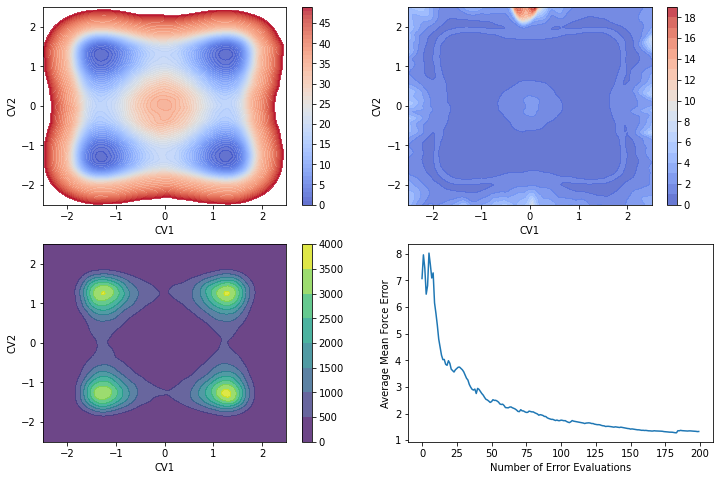

In [2]:
#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_potential")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_potential")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 10, error_pace = 200, min_grid=-2.5, max_grid=2.5)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=-2.5, max_grid=2.5)

#Simpler integration test
[X, Y, FES2] = MFI.intg_2D(Ftot_x, Ftot_y, min_grid=-2.5, max_grid=2.5)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES2, Ftot_den, ofe_map, ofe_history)

In [4]:
np.array((np.pi, np.pi))

array([3.14159265, 3.14159265])